In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
df_vendas = pd.read_csv('../../data/processed/df_vendas_consolidado.csv')
df_vendas['dt_venda'] = pd.to_datetime(df_vendas['dt_venda'])
df_vendas.drop(columns=['vlr_venda_tabelado_mean', 'vlr_desconto_mean', 'categoria_produto', 'sub_categoria_produto', 'linha_produto'], inplace=True)
df_vendas.head()

,dt_venda,key_loja,cod_produto,qtd_vendas
0,2024-01-02,1,48062,1
1,2024-01-02,1,48635,1
2,2024-01-02,1,82060,1
3,2024-01-02,2,1650,1
4,2024-01-02,2,48060,2


In [5]:
df_estoque_ruptura = pd.read_csv('../../data/processed/dados_estoque_ruptura.csv')
df_estoque_ruptura['dt_estoque'] = pd.to_datetime(df_estoque_ruptura['dt_estoque'])
df_estoque_ruptura['is_ruptura'] = df_estoque_ruptura['is_ruptura'].apply(int)
df_estoque_ruptura.head()

,key_loja,cod_produto,dt_estoque,qt_estoque,is_ruptura
0,1,1428,2024-01-01,108.0,0
1,1,1428,2024-01-02,108.0,0
2,1,1428,2024-01-03,108.0,0
3,1,1428,2024-01-04,108.0,0
4,1,1428,2024-01-05,108.0,0


In [6]:
df_estoque_venda = df_estoque_ruptura.merge(df_vendas, left_on=['dt_estoque', 'key_loja', 'cod_produto'], right_on=['dt_venda', 'key_loja', 'cod_produto'], how='left')
df_estoque_venda.drop(columns=['dt_venda'],inplace=True)
df_estoque_venda.head()

,key_loja,cod_produto,dt_estoque,qt_estoque,is_ruptura,qtd_vendas
0,1,1428,2024-01-01,108.0,0,NaN
1,1,1428,2024-01-02,108.0,0,NaN
2,1,1428,2024-01-03,108.0,0,NaN
3,1,1428,2024-01-04,108.0,0,NaN
4,1,1428,2024-01-05,108.0,0,2.0


- Para os casos onde o produto tinha estoque na loja e não foi vendido irei atribuir o valor de 0 vendas.
- Para os casos de ruptura vai permanecer com vendas Nula, pois são vendas impossiveis de poderem ocorrer depis irei remover para etapa de classificação de demanda

In [7]:
df_estoque_venda.loc[(df_estoque_venda['is_ruptura']==0)&(df_estoque_venda['qtd_vendas'].isnull()), 'qtd_vendas'] = 0
df_estoque_venda.head()

,key_loja,cod_produto,dt_estoque,qt_estoque,is_ruptura,qtd_vendas
0,1,1428,2024-01-01,108.0,0,0.0
1,1,1428,2024-01-02,108.0,0,0.0
2,1,1428,2024-01-03,108.0,0,0.0
3,1,1428,2024-01-04,108.0,0,0.0
4,1,1428,2024-01-05,108.0,0,2.0


# Classificação da Demanda

- Para podermos construir modelos para estimar a venda dos skus precisamos primeiro entender como é o comportamento de cada demanda
- Nesse projeto vou utizar a seguinte classificação [link](https://frepple.com/blog/demand-classification/):
- Demanda Smooth (ADI < 1,32 e CV² < 0,49)  : 
    - A demanda é muito regular em tempo e quantidade. Portanto, é fácil prever e você não terá problemas para atingir um nível baixo de erro de previsão. 
- Demanda Intermittent (ADI >= 1,32 e CV² < 0,49): 
    - O histórico de demanda mostra uma variação muito pequena na quantidade demandada, mas uma alta variação no intervalo entre duas demandas. Embora métodos específicos de previsão abordem demandas intermitentes, a margem de erro da previsão é consideravelmente maior.
- Demanda Erratic (ADI < 1,32 e CV² >= 0,49): 
    - A demanda apresenta ocorrências regulares ao longo do tempo, com grandes variações quantitativas. A precisão da sua previsão permanece instável.
- Demanda Lumpy (ADI >= 1,32 e CV² >= 0,49): 
    - A demanda é caracterizada por uma grande variação em quantidade e em tempo. É realmente impossível produzir uma previsão confiável, independentemente das ferramentas de previsão utilizadas. Esse tipo específico de padrão de demanda é imprevisível.

In [8]:
df_valid = df_estoque_venda[df_estoque_venda['is_ruptura']==0]
df_valid

,key_loja,cod_produto,dt_estoque,qt_estoque,is_ruptura,qtd_vendas
0,1,1428,2024-01-01,108.0,0,0.0
1,1,1428,2024-01-02,108.0,0,0.0
2,1,1428,2024-01-03,108.0,0,0.0
3,1,1428,2024-01-04,108.0,0,0.0
4,1,1428,2024-01-05,108.0,0,2.0
...,...,...,...,...,...,...
282404,8,84206,2024-09-16,2.0,0,2.0
282406,8,84206,2024-09-18,1.0,0,1.0
282412,8,84206,2024-09-24,1.0,0,1.0
282413,8,84206,2024-09-25,5.0,0,5.0


In [405]:
df_valid[(df_valid['key_loja']==3)&(df_valid['cod_produto']==22230)]

,key_loja,cod_produto,dt_estoque,qt_estoque,is_ruptura,qtd_vendas
75677,3,22230,2024-01-04,1.0,0,1.0


In [415]:
df_tmp = df_valid.groupby('key_loja')['cod_produto'].value_counts().reset_index()
df_tmp[df_tmp['count']>7]

,key_loja,cod_produto,count
0,1,1640,366
1,1,1650,366
2,1,25458,366
3,1,48060,366
4,1,48281,366
...,...,...,...
691,8,82250,36
692,8,48730,32
693,8,77241,24
694,8,22230,15


In [361]:
def remover_outliers_por_produto(df):
    def filtro_outlier(grupo):
        q1 = grupo['qtd_vendas'].quantile(0.25)
        q3 = grupo['qtd_vendas'].quantile(0.75)
        iqr = q3 - q1
        limite_inf = q1 - 10 * iqr
        limite_sup = q3 + 10 * iqr
        
        cond_outlier = (grupo['qtd_vendas'] < limite_inf) | (grupo['qtd_vendas'] > limite_sup)
        grupo.loc[cond_outlier, 'qtd_vendas'] = grupo['qtd_vendas'].median()
        
        return grupo 
    
    return df.groupby(['key_loja', 'cod_produto'], group_keys=False).apply(filtro_outlier)

- Optei pelo threshold de 10 pois gostaria de tirar apenas comportamentos absurdos, alguns desses comportamentos podem ser devidos a campanhas ou promoções

In [362]:
df_valid_sem_outliers = remover_outliers_por_produto(df_valid)
df_valid_sem_outliers

C:\Users\Carlos\AppData\Local\Temp\ipykernel_11896\1365850440.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(['key_loja', 'cod_produto'], group_keys=False).apply(filtro_outlier)


,key_loja,cod_produto,dt_estoque,qt_estoque,is_ruptura,qtd_vendas
0,1,1428,2024-01-01,108.0,0,0.0
1,1,1428,2024-01-02,108.0,0,0.0
2,1,1428,2024-01-03,108.0,0,0.0
3,1,1428,2024-01-04,108.0,0,0.0
4,1,1428,2024-01-05,108.0,0,0.0
...,...,...,...,...,...,...
282404,8,84206,2024-09-16,2.0,0,2.0
282406,8,84206,2024-09-18,1.0,0,1.0
282412,8,84206,2024-09-24,1.0,0,1.0
282413,8,84206,2024-09-25,5.0,0,5.0


In [488]:
def calcualte_adi_cv2(grupo):
    vendas = grupo.sort_values('dt_estoque')['qtd_vendas'].values
    n_periodos = len(vendas)
    n_dias_com_demanda = np.sum(vendas > 0)


    if (n_dias_com_demanda == 0) | (n_periodos<25):
        adi = np.nan  # intervalo infinito, substituído por total observado
        media = 0
        std = 0
        cv2 = 0
    else:
        adi = n_periodos / n_dias_com_demanda
        adi = np.clip(adi, 1, n_periodos)  # evita ADI < 1
        media = np.mean(vendas)
        std = np.std(vendas, ddof=0)
        cv2 = (std / media)**2 if media > 0 else 0
    
    return pd.Series({
        'adi': adi,
        'cv2': cv2,
        'demanda_media': media,
    })

In [489]:
def classificar_adi_cv2(adi, cv2, adi_corte, cv2_corte):    
    if adi < adi_corte and cv2 < cv2_corte:
        tipo = 'Smooth'
    elif adi >= adi_corte and cv2 < cv2_corte:
        tipo = 'Intermittent'
    elif adi < adi_corte and cv2 >= cv2_corte:
        tipo = 'Erratic'
    elif adi == np.nan:
        tipo = 'Sem Tipo'
    else:
        tipo = 'Lumpy'
    
    return tipo

In [490]:
def create_graph_adi_x_cv2(df, ADI_CORTE, CV2_CORTE):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 6))
    
    # Scatter plot
    plt.scatter(df['cv2'], df['adi'], alpha=0.6)
   
    # Cortes padrão da literatura (opcional, pode alterar depois)
    plt.axvline(CV2_CORTE, color='red', linestyle='--', label=f'CV² = {CV2_CORTE}')
    plt.axhline(ADI_CORTE, color='red', linestyle='--', label=f'ADI = {ADI_CORTE}')
    
    plt.xlabel('CV²')
    plt.ylabel('ADI')
    plt.title('Dispersão: ADI vs CV²')
    plt.grid(True)
    plt.legend()
    # plt.xlim(0, max(1, resultado['CV2'].quantile(0.95)))  # foca nos 95% menores
    # plt.ylim(0, max(1, resultado['ADI'].quantile(0.95)))  # foca nos 95% menores
    plt.show()

In [491]:
def crete_graph_demand(serie, cod_produto, loja, tipo):
    plt.figure(figsize=(16, 5))  # gráfico mais largo
    
    # Criar gráfico de barras
    plt.bar(serie['dia_seq'], serie['qtd_vendas'], width=0.8, align='center')
    
    # Título e eixos
    plt.title(f'Série de Vendas ({tipo}) - Produto {cod_produto}, Loja {loja}', fontsize=14)
    plt.xlabel('Dia na Série')
    plt.ylabel('Quantidade Vendida')
    plt.xticks(rotation=45)  # rotaciona datas se estiverem próximas
    plt.grid(axis='y')
    
    # Deixa espaço entre as datas se estiverem muito coladas
    plt.tight_layout()
    plt.show()

In [492]:
df_adi_cv2_calculate = df_valid_sem_outliers.groupby(['cod_produto', 'key_loja']).apply(calcualte_adi_cv2).reset_index()
df_adi_cv2_calculate.head()

C:\Users\Carlos\AppData\Local\Temp\ipykernel_11896\3210788978.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_adi_cv2_calculate = df_valid_sem_outliers.groupby(['cod_produto', 'key_loja']).apply(calcualte_adi_cv2).reset_index()


,cod_produto,key_loja,adi,cv2,demanda_media
0,1428,1,NaN,0.000000,0.000000
1,1428,2,3.094340,3.456522,0.560976
2,1428,3,NaN,0.000000,0.000000
3,1428,4,2.185484,3.224955,1.715867
4,1428,5,2.081395,2.943287,1.379888


In [493]:
df_adi_cv2_calculate = df_adi_cv2_calculate[~df_adi_cv2_calculate['adi'].isnull()]
df_adi_cv2_calculate

,cod_produto,key_loja,adi,cv2,demanda_media
1,1428,2,3.094340,3.456522,0.560976
3,1428,4,2.185484,3.224955,1.715867
4,1428,5,2.081395,2.943287,1.379888
5,1428,6,2.361290,3.177712,1.071038
7,1428,8,1.497942,2.147084,3.793956
...,...,...,...,...,...
690,84206,2,2.857143,2.750000,0.533333
692,84206,4,1.155556,0.789312,1.961538
693,84206,5,2.014085,1.602600,0.699301
694,84206,6,3.681818,3.694694,0.432099


In [494]:
print("Resumo estatístico - ADI:")
print(df_adi_cv2_calculate['adi'].describe())
print("\nResumo estatístico - CV²:")
print(df_adi_cv2_calculate['cv2'].describe())

Resumo estatístico - ADI:
count    342.000000
mean       2.295199
std        0.846255
min        1.000000
25%        1.568605
50%        2.226553
75%        2.927250
max        4.266667
Name: adi, dtype: float64

Resumo estatístico - CV²:
count    342.000000
mean       2.663584
std        1.191730
min        0.000000
25%        1.880596
50%        2.675091
75%        3.387267
max        9.382857
Name: cv2, dtype: float64


In [495]:
percentis = np.arange(0.10, 0.91, 0.05)

# Calcular os percentis
adi_percentis = df_adi_cv2_calculate['adi'].quantile(percentis)
cv2_percentis = df_adi_cv2_calculate['cv2'].quantile(percentis)

# Mostrar formatado
print("📊 Percentis de ADI:")
print(adi_percentis.round(2).to_string())

print("\n📊 Percentis de CV²:")
print(cv2_percentis.round(2).to_string())

📊 Percentis de ADI:
0.10    1.25
0.15    1.37
0.20    1.46
0.25    1.57
0.30    1.72
0.35    1.84
0.40    1.94
0.45    2.07
0.50    2.23
0.55    2.35
0.60    2.44
0.65    2.59
0.70    2.76
0.75    2.93
0.80    3.10
0.85    3.44
0.90    3.60

📊 Percentis de CV²:
0.10    1.28
0.15    1.44
0.20    1.64
0.25    1.88
0.30    2.04
0.35    2.23
0.40    2.39
0.45    2.55
0.50    2.68
0.55    2.83
0.60    2.94
0.65    3.08
0.70    3.22
0.75    3.39
0.80    3.68
0.85    3.88
0.90    4.12


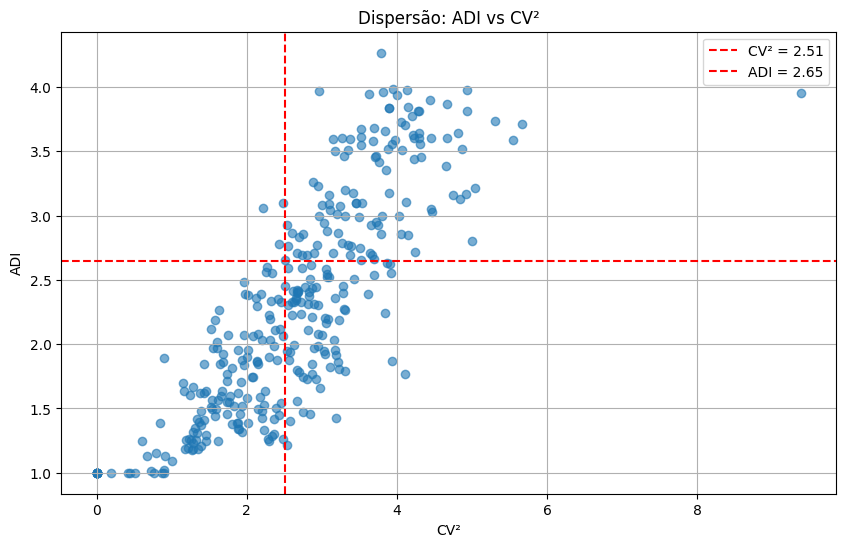

In [496]:
adi_corte = 2.65
cv2_corte = 2.51

# adi_corte = 2.69
# cv2_corte = 2.42


df_adi_cv2_calculate['tipo_demanda'] = df_adi_cv2_calculate.apply(lambda x: classificar_adi_cv2(x['adi'], x['cv2'], adi_corte, cv2_corte) ,axis=1)
create_graph_adi_x_cv2(df_adi_cv2_calculate, adi_corte, cv2_corte)

In [497]:
df_adi_cv2_calculate['tipo_demanda'].value_counts(normalize=True)

tipo_demanda
Smooth          0.423977
Lumpy           0.327485
Erratic         0.236842
Intermittent    0.011696
Name: proportion, dtype: float64

In [498]:
def filter_sku_categoria_mais_prox_cortes(df, tipo, adi_corte, cv2_corte):
    df_tipo = df[df['tipo_demanda'] == tipo].copy()
    df_tipo['distancia_corte'] = np.sqrt((df_tipo['adi'] - adi_corte)**2 + (df_tipo['cv2'] - cv2_corte)**2)

    df_mais_proximo = df_tipo.nsmallest(1, 'distancia_corte')

    return df_mais_proximo

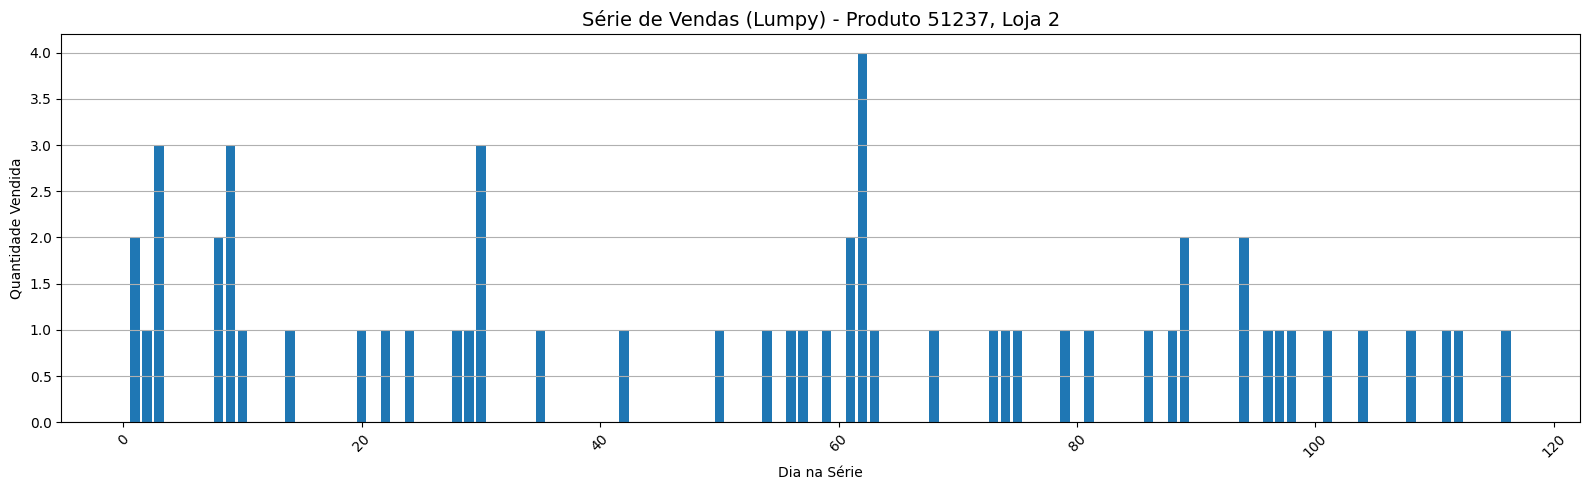

In [499]:
lumpy_mais_proximo = filter_sku_categoria_mais_prox_cortes(df_adi_cv2_calculate, 'Lumpy', adi_corte, cv2_corte)

serie = df_valid[
    (df_valid['cod_produto'] == lumpy_mais_proximo['cod_produto'].values[0]) &
    (df_valid['key_loja'] == lumpy_mais_proximo['key_loja'].values[0])
].sort_values('dt_estoque')

serie = serie.reset_index(drop=True)
serie['dia_seq'] = serie.index + 1

crete_graph_demand(serie, lumpy_mais_proximo['cod_produto'].values[0], lumpy_mais_proximo['key_loja'].values[0], 'Lumpy')

In [500]:
lumpy_mais_proximo

,cod_produto,key_loja,adi,cv2,demanda_media,tipo_demanda,distancia_corte
389,51237,2,2.761905,2.55102,0.482759,Lumpy,0.119186


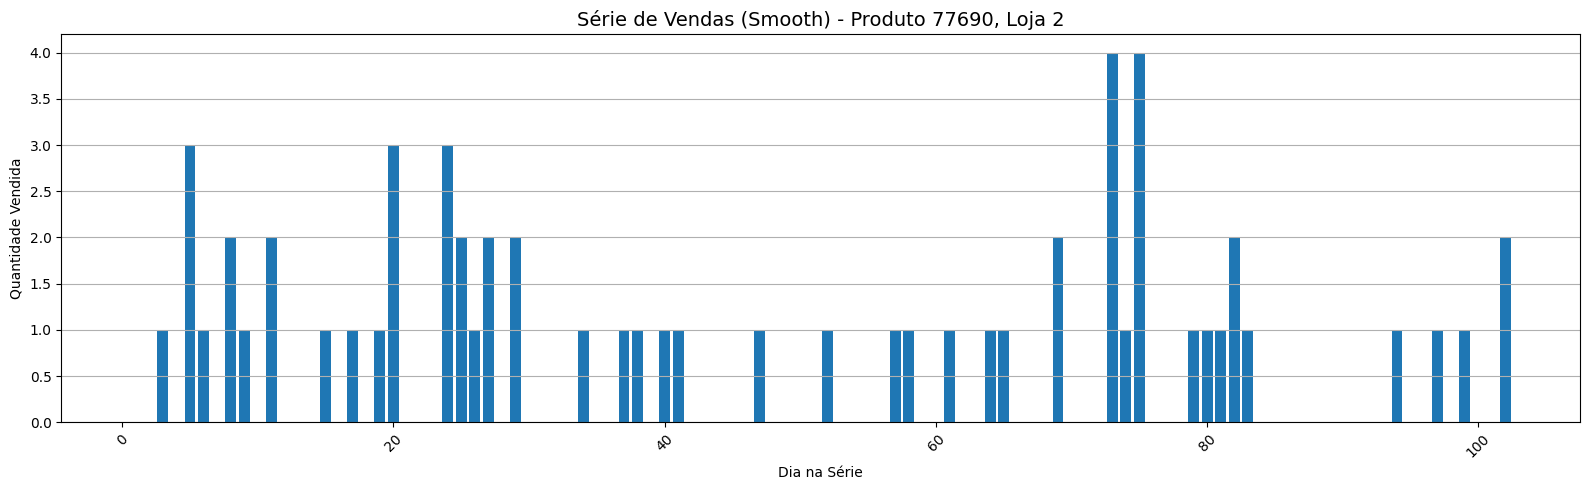

In [501]:
smooth_mais_proximo = filter_sku_categoria_mais_prox_cortes(df_adi_cv2_calculate, 'Smooth', adi_corte, cv2_corte)

serie = df_valid[
    (df_valid['cod_produto'] == smooth_mais_proximo['cod_produto'].values[0]) &
    (df_valid['key_loja'] == smooth_mais_proximo['key_loja'].values[0])
].sort_values('dt_estoque')

serie = serie.reset_index(drop=True)
serie['dia_seq'] = serie.index + 1

crete_graph_demand(serie, smooth_mais_proximo['cod_produto'].values[0], smooth_mais_proximo['key_loja'].values[0], 'Smooth')

In [502]:
smooth_mais_proximo

,cod_produto,key_loja,adi,cv2,demanda_media,tipo_demanda,distancia_corte
563,77690,2,2.55,2.343333,0.588235,Smooth,0.194365


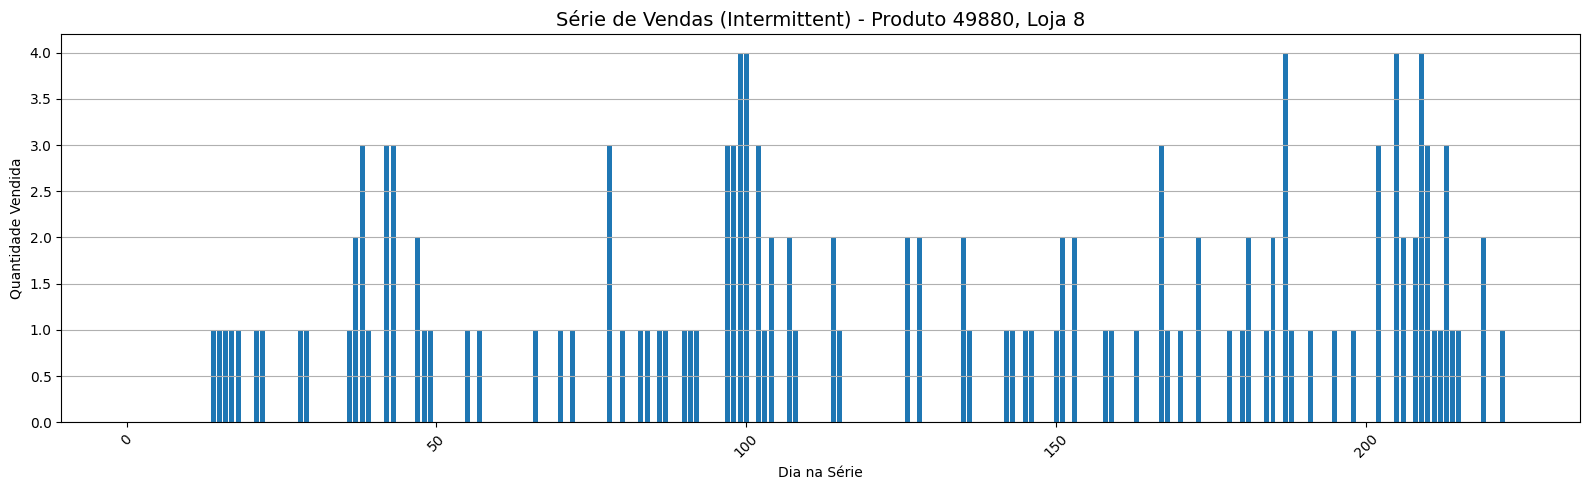

In [503]:
intermittent_mais_proximo = filter_sku_categoria_mais_prox_cortes(df_adi_cv2_calculate, 'Intermittent', adi_corte, cv2_corte)

serie = df_valid[
    (df_valid['cod_produto'] == intermittent_mais_proximo['cod_produto'].values[0]) &
    (df_valid['key_loja'] == intermittent_mais_proximo['key_loja'].values[0])
].sort_values('dt_estoque')

serie = serie.reset_index(drop=True)
serie['dia_seq'] = serie.index + 1

crete_graph_demand(serie, intermittent_mais_proximo['cod_produto'].values[0], intermittent_mais_proximo['key_loja'].values[0], 'Intermittent')

In [504]:
intermittent_mais_proximo

,cod_produto,key_loja,adi,cv2,demanda_media,tipo_demanda,distancia_corte
291,49880,8,2.654762,2.504982,0.61435,Intermittent,0.006918


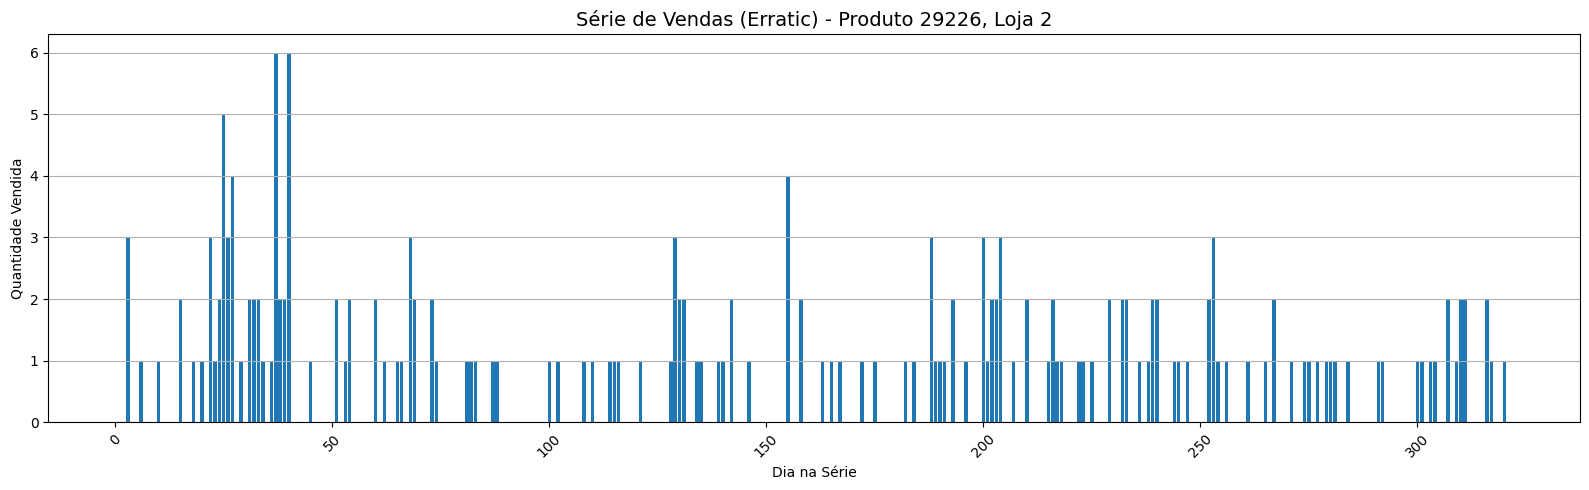

In [505]:
erratic_mais_proximo = filter_sku_categoria_mais_prox_cortes(df_adi_cv2_calculate, 'Erratic', adi_corte, cv2_corte)

serie = df_valid[
    (df_valid['cod_produto'] == erratic_mais_proximo['cod_produto'].values[0]) &
    (df_valid['key_loja'] == erratic_mais_proximo['key_loja'].values[0])
].sort_values('dt_estoque')

serie = serie.reset_index(drop=True)
serie['dia_seq'] = serie.index + 1

crete_graph_demand(serie, erratic_mais_proximo['cod_produto'].values[0], erratic_mais_proximo['key_loja'].values[0], 'Erratic')

## Verificando Classificação Demanda

In [506]:
def filter_sku_categoria_mais_distante_cortes(df, tipo, adi_corte, cv2_corte):
    df_tipo = df[df['tipo_demanda'] == tipo].copy()
    df_tipo['distancia_corte'] = np.sqrt((df_tipo['adi'] - adi_corte)**2 + (df_tipo['cv2'] - cv2_corte)**2)

    df_mais_distante = df_tipo.nlargest(1, 'distancia_corte')

    return df_mais_distante

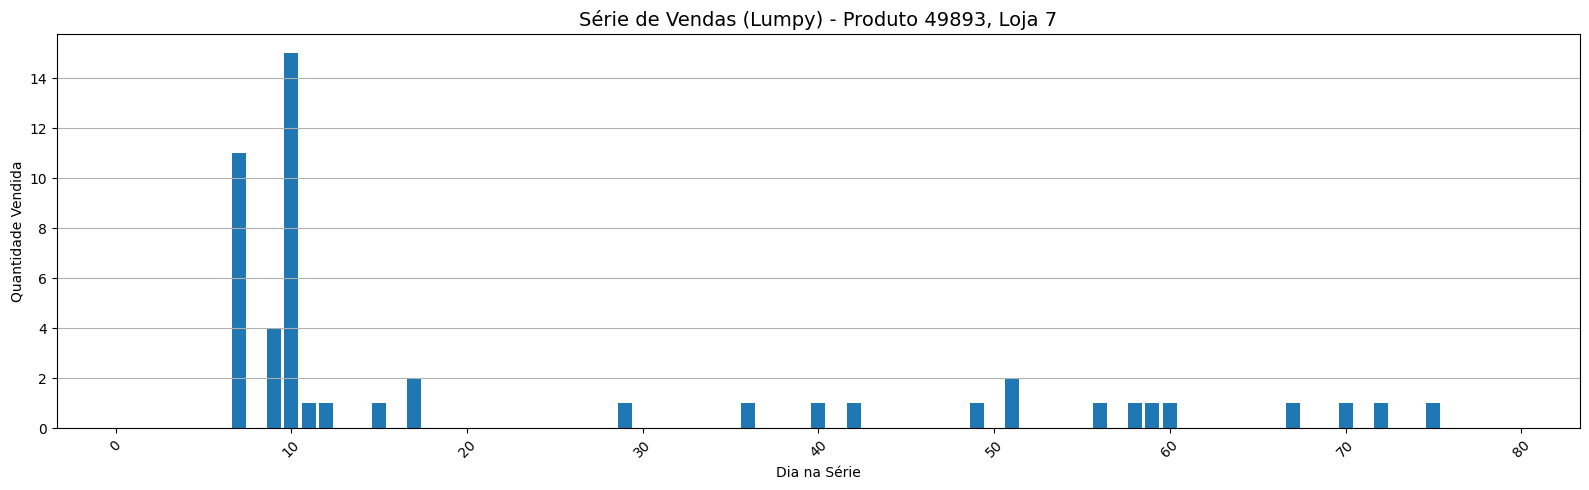

In [507]:
lumpy_mais_distante = filter_sku_categoria_mais_distante_cortes(df_adi_cv2_calculate, 'Lumpy', adi_corte, cv2_corte)

serie = df_valid[
    (df_valid['cod_produto'] == lumpy_mais_distante['cod_produto'].values[0]) &
    (df_valid['key_loja'] == lumpy_mais_distante['key_loja'].values[0])
].sort_values('dt_estoque')

serie = serie.reset_index(drop=True)
serie['dia_seq'] = serie.index + 1

crete_graph_demand(serie, lumpy_mais_distante['cod_produto'].values[0], lumpy_mais_distante['key_loja'].values[0], 'Lumpy')

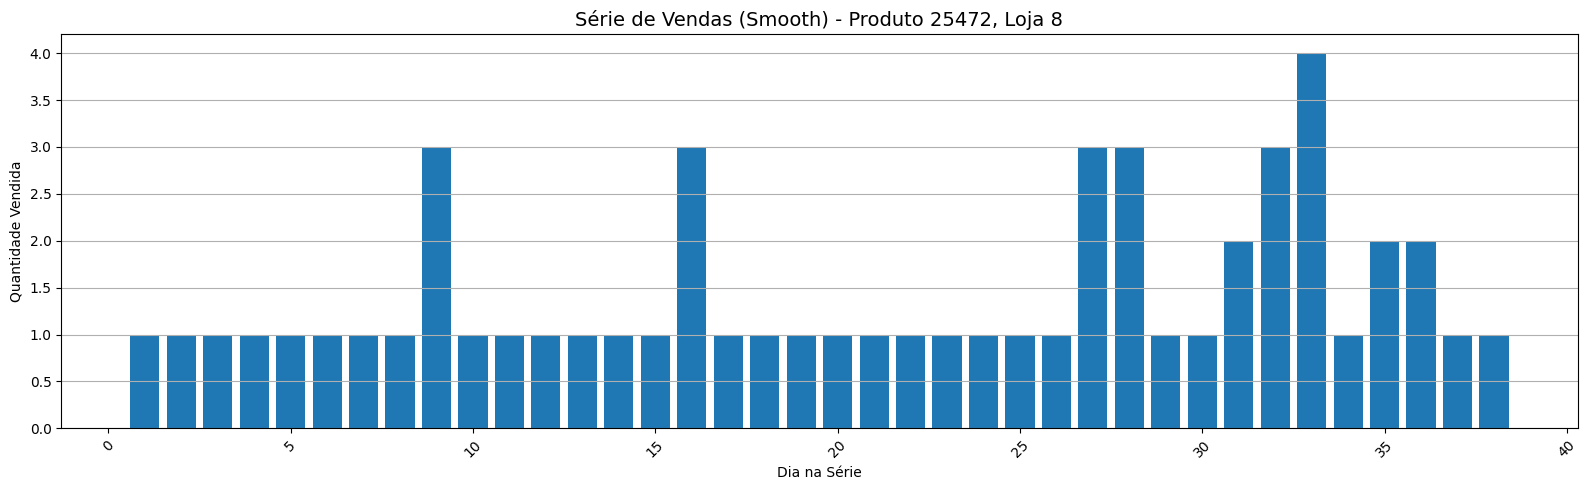

In [508]:
smooth_mais_distante = filter_sku_categoria_mais_distante_cortes(df_adi_cv2_calculate, 'Smooth', adi_corte, cv2_corte)

serie = df_valid[
    (df_valid['cod_produto'] == smooth_mais_distante['cod_produto'].values[0]) &
    (df_valid['key_loja'] == smooth_mais_distante['key_loja'].values[0])
].sort_values('dt_estoque')

serie = serie.reset_index(drop=True)
serie['dia_seq'] = serie.index + 1

crete_graph_demand(serie, smooth_mais_distante['cod_produto'].values[0], smooth_mais_distante['key_loja'].values[0], 'Smooth')

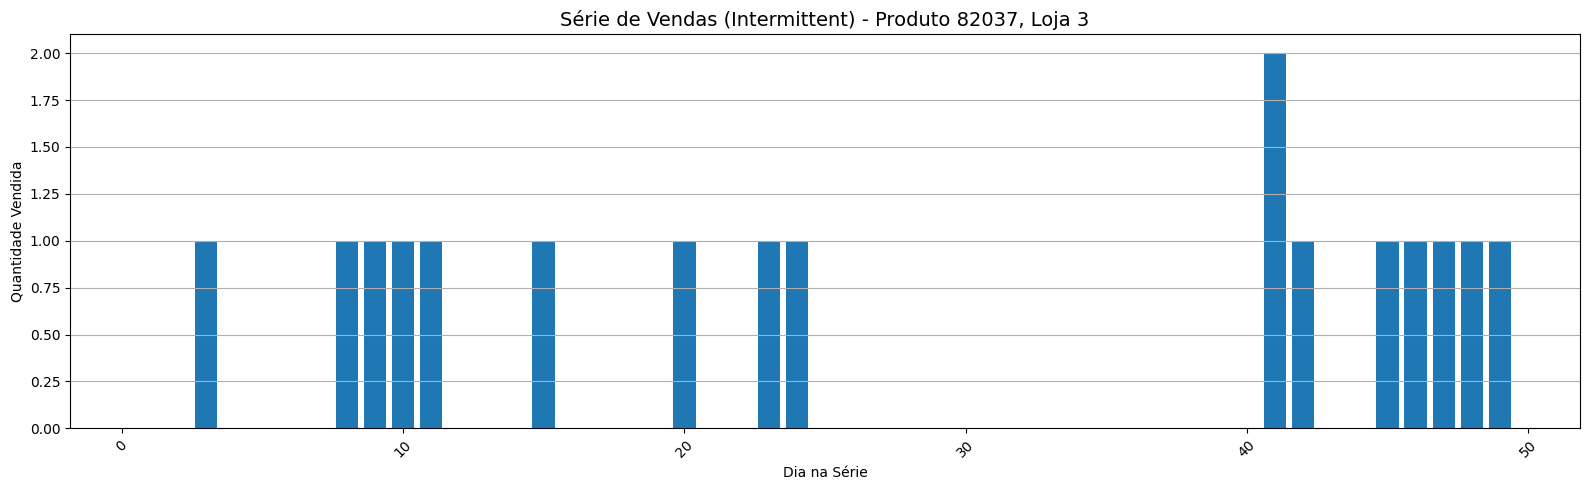

In [509]:
intermittent_mais_distante = filter_sku_categoria_mais_distante_cortes(df_adi_cv2_calculate, 'Intermittent', adi_corte, cv2_corte)

serie = df_valid[
    (df_valid['cod_produto'] == intermittent_mais_distante['cod_produto'].values[0]) &
    (df_valid['key_loja'] == intermittent_mais_distante['key_loja'].values[0])
].sort_values('dt_estoque')

serie = serie.reset_index(drop=True)
serie['dia_seq'] = serie.index + 1

crete_graph_demand(serie, intermittent_mais_distante['cod_produto'].values[0], intermittent_mais_distante['key_loja'].values[0], 'Intermittent')

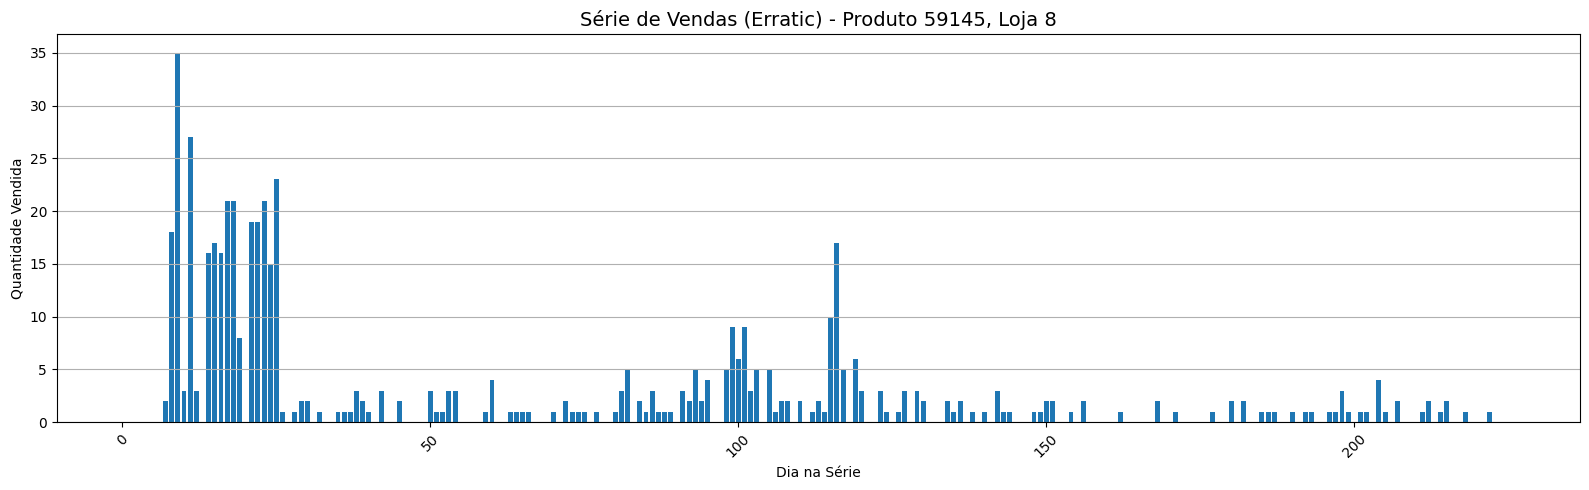

In [510]:
erratic_mais_distante = filter_sku_categoria_mais_distante_cortes(df_adi_cv2_calculate, 'Erratic', adi_corte, cv2_corte)

serie = df_valid[
    (df_valid['cod_produto'] == erratic_mais_distante['cod_produto'].values[0]) &
    (df_valid['key_loja'] == erratic_mais_distante['key_loja'].values[0])
].sort_values('dt_estoque')

serie = serie.reset_index(drop=True)
serie['dia_seq'] = serie.index + 1

crete_graph_demand(serie, erratic_mais_distante['cod_produto'].values[0], erratic_mais_distante['key_loja'].values[0], 'Erratic')

# Interpolação

- Uma vez que classificamos as demandas precisamos realizar a interpolação dos dados faltantes (dia em que o produto teve ruptura). para que o modelo tenha a base completa para ser treinado
- O resultado da etapa de classificação vai ser importante aqui pois cada Tipo de Demanda exige uma técnia de interpolação diferente

- Para Demandas Smooth vou utilizar **Linear**:
    - A interpolação linear não superestima nem suaviza demais os dados.
    - Ela assume uma evolução constante entre dois pontos conhecidos, o que é realista em séries de vendas, onde o crescimento ou queda costuma ser gradual.

In [519]:
df_estoque_venda_demanda = df_estoque_venda.merge(df_adi_cv2_calculate, on=['key_loja', 'cod_produto'], how='left')
df_estoque_venda_demanda.drop(columns=['adi', 'cv2', 'demanda_media'],inplace=True)
df_estoque_venda_demanda.head()

,key_loja,cod_produto,dt_estoque,qt_estoque,is_ruptura,qtd_vendas,tipo_demanda
0,1,1428,2024-01-01,108.0,0,0.0,NaN
1,1,1428,2024-01-02,108.0,0,0.0,NaN
2,1,1428,2024-01-03,108.0,0,0.0,NaN
3,1,1428,2024-01-04,108.0,0,0.0,NaN
4,1,1428,2024-01-05,108.0,0,2.0,NaN


In [523]:
def interpolar_linear(grupo):
    grupo = grupo.sort_values('dt_estoque')
    grupo['qtd_venda_interp'] = grupo['qtd_vendas'].interpolate(method='linear', limit_direction='both')
    
    return grupo

In [536]:
def interpolar_foward_fill(grupo):
    grupo = grupo.sort_values('dt_estoque')
    grupo['qtd_venda_interp'] = grupo['qtd_vendas'].ffill().bfill()
    
    return grupo

In [554]:
def interpolar_media_movel(grupo, janela=3):
    grupo = grupo.sort_values('dt_estoque').copy()
    mov_avg = grupo['qtd_vendas'].rolling(window=janela, min_periods=1, center=False).mean()
    
    grupo['qtd_venda_interp'] = grupo['qtd_vendas']
    grupo.loc[grupo['qtd_vendas'].isna(), 'qtd_venda_interp'] = mov_avg[grupo['qtd_vendas'].isna()]
    
    grupo['qtd_venda_interp'] = grupo['qtd_venda_interp'].fillna(mov_avg)
    grupo['qtd_venda_interp'] = grupo['qtd_venda_interp'].ffill().bfill()
    
    return grupo

In [ ]:
    # if adi < adi_corte and cv2 < cv2_corte:
    #     tipo = 
    # elif adi >= adi_corte and cv2 < cv2_corte:
    #     tipo = 
    # elif adi < adi_corte and cv2 >= cv2_corte:
    #     tipo = 'Erratic'
    # elif adi == np.nan:
    #     tipo = 'Sem Tipo'
    # else:
    #     tipo = 'Lumpy'

## Smooth

In [534]:
df_smooth = df_estoque_venda_demanda[df_estoque_venda_demanda['tipo_demanda'] == 'Smooth']
df_smooth_interpolado = df_smooth.groupby(['key_loja', 'cod_produto'], group_keys=False).apply(interpolar_linear)
df_smooth_interpolado['qtd_venda_interp'] = df_smooth_interpolado['qtd_venda_interp'].astype(int) 
df_smooth_interpolado.head()

C:\Users\Carlos\AppData\Local\Temp\ipykernel_11896\2017398574.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_smooth_interpolado = df_smooth.groupby(['key_loja', 'cod_produto'], group_keys=False).apply(interpolar_linear)


,key_loja,cod_produto,dt_estoque,qt_estoque,is_ruptura,qtd_vendas,tipo_demanda,qtd_venda_interp
1830,1,25458,2024-01-01,46.0,0,0.0,Smooth,0
1831,1,25458,2024-01-02,46.0,0,0.0,Smooth,0
1832,1,25458,2024-01-03,46.0,0,0.0,Smooth,0
1833,1,25458,2024-01-04,46.0,0,1.0,Smooth,1
1834,1,25458,2024-01-05,46.0,0,2.0,Smooth,2


## Intermittent

In [537]:
df_intermittent = df_estoque_venda_demanda[df_estoque_venda_demanda['tipo_demanda'] == 'Intermittent']
df_intermittent_interpolado = df_intermittent.groupby(['key_loja', 'cod_produto'], group_keys=False).apply(interpolar_foward_fill)
df_intermittent_interpolado['qtd_venda_interp'] = df_intermittent_interpolado['qtd_venda_interp'].astype(int) 
df_intermittent_interpolado.head()

C:\Users\Carlos\AppData\Local\Temp\ipykernel_11896\1199914783.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_intermittent_interpolado = df_intermittent.groupby(['key_loja', 'cod_produto'], group_keys=False).apply(interpolar_foward_fill)


,key_loja,cod_produto,dt_estoque,qt_estoque,is_ruptura,qtd_vendas,tipo_demanda,qtd_venda_interp
80798,3,48253,2024-01-01,15.0,0,0.0,Intermittent,0
80799,3,48253,2024-01-02,15.0,0,0.0,Intermittent,0
80800,3,48253,2024-01-03,15.0,0,0.0,Intermittent,0
80801,3,48253,2024-01-04,15.0,0,0.0,Intermittent,0
80802,3,48253,2024-01-05,15.0,0,0.0,Intermittent,0


In [538]:
df_intermittent_interpolado['qtd_venda_interp'].value_counts()

qtd_venda_interp
1    989
0    400
2     44
3     23
4      8
Name: count, dtype: int64

## Lumpy

- Para Deamndas do tipo Lumpy não irei realizar interpolação, vou utilizar métodos especificos para conseguir treinar e prever
    - Esse tipo de demanda ocorre de forma esporádica e com valores altamente variáveis.
    - Pode ter muitos períodos com zero e, de repente, um pico muito alto.
    - Interpolar entre zeros e picos cria valores artificiais, que não representam a realidade nem têm lógica de negócio.

In [541]:
df_lumpy = df_estoque_venda_demanda[df_estoque_venda_demanda['tipo_demanda'] == 'Lumpy']
df_lumpy[df_lumpy['is_ruptura']==0].head()

,key_loja,cod_produto,dt_estoque,qt_estoque,is_ruptura,qtd_vendas,tipo_demanda
15754,1,49883,2024-01-17,2.0,0,2.0,Lumpy
15755,1,49883,2024-01-18,1.0,0,0.0,Lumpy
15757,1,49883,2024-01-20,1.0,0,0.0,Lumpy
15758,1,49883,2024-01-21,1.0,0,0.0,Lumpy
15759,1,49883,2024-01-22,1.0,0,0.0,Lumpy


## Erratic

In [555]:
df_erratic = df_estoque_venda_demanda[df_estoque_venda_demanda['tipo_demanda'] == 'Erratic']
df_erratic_interpolado = df_erratic.groupby(['key_loja', 'cod_produto'], group_keys=False).apply(interpolar_media_movel)
df_erratic_interpolado['qtd_venda_interp'] = df_erratic_interpolado['qtd_venda_interp'].astype(int) 
df_erratic_interpolado.head()

C:\Users\Carlos\AppData\Local\Temp\ipykernel_11896\3880633282.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_erratic_interpolado = df_erratic.groupby(['key_loja', 'cod_produto'], group_keys=False).apply(interpolar_media_movel)


,key_loja,cod_produto,dt_estoque,qt_estoque,is_ruptura,qtd_vendas,tipo_demanda,qtd_venda_interp
6954,1,48282,2024-01-01,335.0,0,0.0,Erratic,0
6955,1,48282,2024-01-02,335.0,0,0.0,Erratic,0
6956,1,48282,2024-01-03,335.0,0,1.0,Erratic,1
6957,1,48282,2024-01-04,335.0,0,1.0,Erratic,1
6958,1,48282,2024-01-05,335.0,0,2.0,Erratic,2


## Sem Tipo

- Para os Produtos que nunca tiveram uma venda irei remove-los pois é não irei conseguir criar um modelo de estimativa de demanda
- Para os casos que não consegui definir o tipo da demanda irei adotrar o foward fill:
    - Não cria médias artificiais ou tendências suaves.
    - Apenas replica valores reais existentes próximos.

In [568]:
df_sem_tipo = df_estoque_venda_demanda[df_estoque_venda_demanda['tipo_demanda'].isnull()]
produtos_venda = (df_sem_tipo.groupby(['key_loja', 'cod_produto'])['qtd_vendas'].sum().reset_index())
produtos_venda = produtos_venda[produtos_venda['qtd_vendas'] > 0]

df_sem_tipo_filtrado = df_sem_tipo.merge(produtos_venda[['key_loja', 'cod_produto']], on=['key_loja', 'cod_produto'], how='inner')
df_sem_tipo_filtrado = df_sem_tipo_filtrado.groupby(['key_loja', 'cod_produto'], group_keys=False).apply(interpolar_foward_fill)

df_sem_tipo_filtrado['qtd_venda_interp'] = df_sem_tipo_filtrado['qtd_venda_interp'].astype(int)
df_sem_tipo_filtrado.head()

C:\Users\Carlos\AppData\Local\Temp\ipykernel_11896\3871645697.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sem_tipo_filtrado = df_sem_tipo_filtrado.groupby(['key_loja', 'cod_produto'], group_keys=False).apply(interpolar_foward_fill)


,key_loja,cod_produto,dt_estoque,qt_estoque,is_ruptura,qtd_vendas,tipo_demanda,qtd_venda_interp
0,1,1428,2024-01-01,108.0,0,0.0,NaN,0
1,1,1428,2024-01-02,108.0,0,0.0,NaN,0
2,1,1428,2024-01-03,108.0,0,0.0,NaN,0
3,1,1428,2024-01-04,108.0,0,0.0,NaN,0
4,1,1428,2024-01-05,108.0,0,2.0,NaN,2


## Concat

In [570]:
df_final_interp = pd.concat([df_smooth_interpolado, df_intermittent_interpolado, df_lumpy, df_erratic_interpolado, df_sem_tipo_filtrado], ignore_index=True)
df_final_interp

,key_loja,cod_produto,dt_estoque,qt_estoque,is_ruptura,qtd_vendas,tipo_demanda,qtd_venda_interp
0,1,25458,2024-01-01,46.0,0,0.0,Smooth,0.0
1,1,25458,2024-01-02,46.0,0,0.0,Smooth,0.0
2,1,25458,2024-01-03,46.0,0,0.0,Smooth,0.0
3,1,25458,2024-01-04,46.0,0,1.0,Smooth,1.0
4,1,25458,2024-01-05,46.0,0,2.0,Smooth,2.0
...,...,...,...,...,...,...,...,...
246872,8,81177,2024-12-27,0.0,1,NaN,NaN,0.0
246873,8,81177,2024-12-28,0.0,1,NaN,NaN,0.0
246874,8,81177,2024-12-29,0.0,1,NaN,NaN,0.0
246875,8,81177,2024-12-30,0.0,1,NaN,NaN,0.0


In [571]:
df_final_interp.to_csv('../../data/processed/dados_estoque_vendas_interpolado.csv', index=False)